# Install GPFlow

In [1]:
!pip3 install gpflow

     |████████████████████████████████| 276kB 7.4MB/s 


# Import package

In [6]:
%reload_ext autoreload
%autoreload 2

from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float, default_jitter
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float, triangular, positive

from gpflow.models import GPModel
from gpflow.models.training_mixins import InputData, OutputData, RegressionData
from gpflow.models.training_mixins import ExternalDataTrainingLossMixin
from gpflow.types import MeanAndVariance
import warnings

from scipy.cluster.vq import kmeans
import time
current_milli_time = lambda: int(round(time.time() * 1000))
warnings.filterwarnings("ignore")

# Define SWSGP

In [3]:
class SWSGP(GPModel, ExternalDataTrainingLossMixin):
  def __init__(self, kernel, likelihood, Z, num_data, q_mu=None, q_sqrt=None, **kwargs):
    super().__init__(kernel, likelihood, mean_function=None, num_latent_gps=1)
    self.num_data = num_data
    self.num_ip = len(Z)
    self.inducing_positions = gpflow.models.util.inducingpoint_wrapper(Z)
    self.init_variational_parameters(q_mu, q_sqrt)
    return

  def init_variational_parameters(self, q_mu, q_sqrt):
    q_mu = np.zeros((self.num_ip, 1)) if q_mu is None else q_mu
    q_sqrt = np.eye(self.num_ip) if q_sqrt is None else q_sqrt
    self.q_mu = gpflow.Parameter(q_mu, dtype=default_float())
    self.q_sqrt = gpflow.Parameter(q_sqrt, dtype=triangular())
    return

  def get_active_id_ip(self, Xnew, H):
    # compute the euclidean distance between X and Z
    RX = tf.reshape(tf.reduce_sum(tf.square(Xnew), axis=1), [-1, 1]) # [N, 1]
    RZ = tf.reshape(tf.transpose(tf.reduce_sum(tf.square(self.inducing_positions.Z), axis=1)), [1, -1]) # [1, M]
    XZ = tf.matmul(Xnew, self.inducing_positions.Z, transpose_b=True) # [N, M]
    minus_distance = -(RX - 2 * XZ + RZ) # [N, M]
    _, active_id_ip = tf.nn.top_k(input=minus_distance, k=H, sorted=False) # [N, H]
    return active_id_ip
  
  def get_active_params(self, active_id_ip):
    active_Z = tf.gather(self.inducing_positions.Z, active_id_ip) # [H, D]
    active_q_mu = tf.gather(self.q_mu, active_id_ip) # [H, 1]
    active_s_sqrt = tf.gather(self.q_sqrt, active_id_ip) # [H, M]
    active_s = tf.matmul(active_s_sqrt, active_s_sqrt, transpose_b=True)
    active_s = active_s + default_jitter() * tf.eye(tf.shape(active_q_mu)[0], dtype=default_float())
    active_q_sqrt = tf.linalg.cholesky(active_s) # [H, H]
    return active_Z, active_q_mu, active_q_sqrt
  
  def predict_f_each_sample(self, Xnew, active_Z, active_q_mu, active_q_sqrt, L=None):
    if L is None:
      KHH = self.kernel.K(active_Z) + default_jitter() * tf.eye(tf.shape(active_q_mu)[0], dtype=default_float()) # [H, H]
      L = tf.linalg.cholesky(KHH) # [H, H]
    KHX = self.kernel.K(active_Z, Xnew)
    LiKHX = tf.linalg.triangular_solve(L, KHX, lower=True) # L^{-1} * KZX
    AT = tf.linalg.triangular_solve(tf.transpose(L), LiKHX, lower=False) # LT^{-1} * L^{-1} * KHX
    # Compute fmean = KXH * KHH^{-1} * q_mu
    fmean = tf.matmul(AT, active_q_mu, transpose_a=True) # [N, 1]
    # Compute fvar = diag(KXX) + diag(KXH * KHH^{-1} * active_S * KHH^{-1} * KHX) - diag(KXH * KHH^{-1} * KHX)
    fvar1 = tf.reshape(self.kernel.K_diag(Xnew), [-1, 1]) # [N, 1]
    fvar2 = tf.reshape(tf.reduce_sum(tf.square(tf.matmul(active_q_sqrt, AT, transpose_a=True)), axis=0), [-1, 1]) # [N, 1]
    fvar3 = tf.reshape(tf.reduce_sum(tf.square(LiKHX), axis=0), [-1, 1]) # [N, 1]
    fvar = fvar1 + fvar2 - fvar3 # [N, 1]
    return fmean, fvar

  def prior_kl(self, active_Z, active_q_mu, active_q_sqrt):
    KHH = self.kernel.K(active_Z) + default_jitter() * tf.eye(tf.shape(active_q_mu)[0], dtype=default_float())
    L = tf.linalg.cholesky(KHH)
    log_det_KHH = tf.reduce_sum(tf.math.log(tf.square(tf.linalg.diag_part(L))))
    q_sqrt = tf.squeeze(active_q_sqrt)
    log_det_S = tf.reduce_sum(tf.math.log(tf.square(tf.linalg.diag_part(active_q_sqrt))))
    trace = tf.reduce_sum(tf.square(tf.linalg.triangular_solve(L, active_q_sqrt, lower=True)))
    mahalanobis = tf.reduce_sum(tf.square(tf.linalg.triangular_solve(L, active_q_mu, lower=True)))
    H = tf.cast(tf.shape(active_q_mu)[0], dtype=default_float())
    kl = 0.5 * (log_det_KHH - log_det_S - H + trace + mahalanobis)
    return kl, L

  def build_elbo(self, data: RegressionData, H: int):
    X, Y = data
    list_ll, list_kl = [], []
    list_active_id_ip = self.get_active_id_ip(X, H)
    mini_batch_size = X.get_shape().as_list()[0]
    for id_data in range(mini_batch_size):
      x = tf.gather_nd(params=X, indices=[[id_data]])
      y = tf.gather_nd(params=Y, indices=[[id_data]])
      active_id_ip = tf.transpose(tf.gather_nd(params=list_active_id_ip, indices=[id_data])) # [H]
      active_Z, active_q_mu, active_q_sqrt = self.get_active_params(active_id_ip=active_id_ip)
      kl, L = self.prior_kl(active_Z, active_q_mu, active_q_sqrt)
      fmean, fvar = self.predict_f_each_sample(x, active_Z, active_q_mu, active_q_sqrt, L=L)
      var_exp = self.likelihood.variational_expectations(fmean, fvar, y) # [1, 1]
      ll = tf.reduce_sum(var_exp) # return the sum not scale # ()
      list_ll.append(ll)
      list_kl.append(kl)

    num_data = tf.cast(self.num_data, dtype=default_float())
    mini_batch_size = tf.cast(tf.shape(X)[0], dtype=default_float())
    scale = num_data / mini_batch_size
    ell_term = tf.add_n(list_ll) * scale
    kl_term = tf.add_n(list_ll) / mini_batch_size
    return ell_term - kl_term

  def predict_f(self, Xnew: InputData, H: int) -> MeanAndVariance:
    list_fmean, list_fvar = [], []
    list_active_id_ip = self.get_active_id_ip(Xnew, H)
    mini_batch_size = Xnew.get_shape().as_list()[0]
    for id_data in range(mini_batch_size):
      x = tf.gather_nd(params=Xnew, indices=[[id_data]])
      active_id_ip = tf.transpose(tf.gather_nd(params=list_active_id_ip, indices=[id_data])) # [H]
      active_Z, active_q_mu, active_q_sqrt = self.get_active_params(active_id_ip=active_id_ip)
      fmean, fvar = self.predict_f_each_sample(x, active_Z, active_q_mu, active_q_sqrt)
      list_fmean.append(fmean)
      list_fvar.append(fvar)
    fmeans = tf.reshape(tf.concat(list_fmean, axis=0), [-1, 1]) # [N, 1]
    fvars = tf.reshape(tf.concat(list_fvar, axis=0), [-1, 1]) # [N, 1]
    return fmeans, fvars

  def build_predict(self, Xnew: InputData, H: int) -> MeanAndVariance:
    f_mean, f_var = self.predict_f(Xnew=Xnew, H=H)
    return self.likelihood._predict_mean_and_var(f_mean, f_var)
  
  def maximum_log_likelihood_objective(self, data: RegressionData, H:int) -> tf.Tensor:
    return self.build_elbo(data, H)

# Generate data

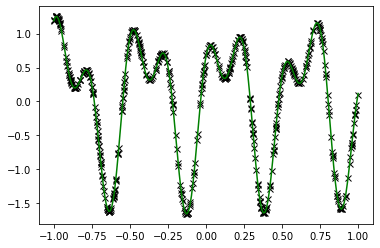

In [4]:
train_size, test_size = 500, 200
low, high = -1.0, 1.0
train_x_np = np.reshape(np.random.uniform(low=low, high=high, size=train_size), (-1, 1))
train_y_np = np.sin(12 * train_x_np) + 0.66 * np.cos(25 * train_x_np)
test_x_np = np.reshape(np.linspace(start=low, stop=high, num=test_size), (-1, 1))
test_y_np = np.sin(12 * test_x_np) + 0.66 * np.cos(25 * test_x_np)
plt.plot(train_x_np, train_y_np, 'kx')
plt.plot(test_x_np, test_y_np, 'g')

# Training process

In [ ]:
# reset graph
tf.compat.v1.reset_default_graph()
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

n_epochs = 10000
evaluate_model_interval = 100
num_ip = 32
H = 4

train_x = tf.constant(train_x_np, dtype=default_float())
train_y = tf.constant(train_y_np, dtype=default_float())
test_x = tf.constant(test_x_np, dtype=default_float())
test_y = tf.constant(test_y_np, dtype=default_float())

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
batch_size = 16
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = train_size // 2
num_batches_per_epoch = train_size // batch_size
original_train_dataset = train_dataset
train_dataset = (train_dataset.repeat().prefetch(prefetch_size).shuffle(buffer_size=shuffle_buffer_size).batch(batch_size))
print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

low, high = np.min(train_x_np), np.max(train_x_np)
Z = np.linspace(low, high, num_ip).reshape(-1, 1)
kernel = gpflow.kernels.Matern52()
likelihood = gpflow.likelihoods.Gaussian()
model = SWSGP(kernel=kernel, likelihood=likelihood, Z=Z, num_data=len(train_x_np))
batched_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(batch_size)
training_loss = model.training_loss_closure(iter(batched_dataset))
optimizer = tf.optimizers.Adam(0.001)

def optimization_step(model: SWSGP, batch: Tuple[tf.Tensor, tf.Tensor], H: int):
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(model.trainable_variables)
    #loss = model.training_loss(batch, H)
    #loss = -model.maximum_log_likelihood_objective(batch, H)
    loss = model._training_loss(batch, H)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

def compute_rmse(predictions: tf.Tensor, labels: tf.Tensor) -> tf.Tensor:
  rmse = tf.sqrt(tf.reduce_mean(tf.square(predictions - labels)))
  return rmse

list_pred_means = []
list_rmse = []
tf_optimization_step = tf.function(optimization_step)
batches = iter(train_dataset)
train_time = 0
for epoch in range(n_epochs):
  for _ in range(ci_niter(num_batches_per_epoch)):
    start_time = current_milli_time()
    tf_optimization_step(model, next(batches), H)
    train_time = train_time + (current_milli_time() - start_time) / 60000
  epoch_id = epoch + 1
  if epoch_id == 1 or epoch_id % evaluate_model_interval == 0:
    pred_means, pred_vars = model.build_predict(test_x, H)
    rmse = compute_rmse(predictions=pred_means, labels=test_y)
    list_pred_means.append(pred_means)
    print("Epoch id: {}, train_time in minutes: {:.2f}, rmse: {:.4f}".format(epoch_id, train_time, rmse.numpy()))

prefetch_size=-1
shuffle_buffer_size=250
num_batches_per_epoch=31
Epoch id: 1, train_time in minutes: 0.26, rmse: 0.8418
Epoch id: 100, train_time in minutes: 2.21, rmse: 0.0737
Epoch id: 200, train_time in minutes: 4.18, rmse: 0.0465
Epoch id: 300, train_time in minutes: 6.15, rmse: 0.0277
Epoch id: 400, train_time in minutes: 8.13, rmse: 0.0266
Epoch id: 500, train_time in minutes: 10.09, rmse: 0.0274
Epoch id: 600, train_time in minutes: 12.05, rmse: 0.0330
Epoch id: 700, train_time in minutes: 14.02, rmse: 0.0261
Epoch id: 800, train_time in minutes: 15.99, rmse: 0.0257
Epoch id: 900, train_time in minutes: 17.96, rmse: 0.0259
Epoch id: 1000, train_time in minutes: 19.92, rmse: 0.0344
Epoch id: 1100, train_time in minutes: 21.88, rmse: 0.0235
Epoch id: 1200, train_time in minutes: 23.84, rmse: 0.0234
Epoch id: 1300, train_time in minutes: 25.81, rmse: 0.0284
Epoch id: 1400, train_time in minutes: 27.77, rmse: 0.0258
Epoch id: 1500, train_time in minutes: 29.74, rmse: 0.0238
Epoch i